In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
import pandas as pd
from tqdm import tqdm

# DL library imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

In [2]:
# Dataset: Fashion MNIST
dataset_labels = ['TShirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

# necessary image transform i.e. convert to Tensor, normalize
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
test_transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the Train and Test set
train_set = datasets.FashionMNIST('.', train=True, download=False, transform=train_transform)
test_set = datasets.FashionMNIST('.', train=False, download=False, transform=test_transform)

In [3]:
NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 64
TRAIN_BATCH_SIZE = 16
VALID_SIZE = 0.2 

In [4]:
len_train_set = len(train_set)
index_list = list(range(len_train_set))
np.random.shuffle(index_list)
split_index = int(len_train_set * VALID_SIZE)
train_idx, valid_idx = index_list[split_index:], index_list[:split_index]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
valid_loader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE,  sampler=valid_sampler, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=TEST_BATCH_SIZE,  shuffle=True,num_workers=NUM_WORKERS)

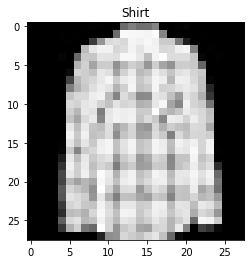

In [6]:
img, label = next(iter(train_loader))
plt.imshow(img[0].numpy().squeeze(), cmap = 'Greys_r')
plt.title(f'{dataset_labels[label[0].item()]}')
plt.show()

In [7]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128, bias=True)
        self.fc2 = nn.Linear(128, 64, bias=True)
        self.fc3 = nn.Linear(64, 32, bias=True)
        self.fc4 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
# Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)

In [9]:
from modelMetrics import computeInferenceTime, getModelFileSize, profile, getModelSize

def print_model_metrics(model, dummy_input):
    print("Model Size: ", str(round(getModelSize(model),3)),"Mb")
    print("File Size: ", str(round(getModelFileSize(model),3)),"Mb")
    print("Inference Time: ",str(round(computeInferenceTime(model,dummy_input, device),5)),"s")
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops = 2 * macs
    print("Mega FLOPS: ", str(flops * 1e-6))
    print("Mega MACs: ", str(macs * 1e-6))
    print("Mega Params: ", str(params * 1e-6))
    return round(computeInferenceTime(model,dummy_input, device),5)

random_input = torch.rand(2, 28, 28).to(device)
print_model_metrics(model, random_input)

Model Size:  0.424 Mb
File Size:  0.447 Mb
Inference Time:  0.00254 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


7e-05

In [10]:
def get_model_sparsity(model):
    totalElements = 0
    totalZeroElements = 0
    for name, module in model.named_children():
        numElementsInLayer = float(module.weight.nelement())
        numZeroElementsInLayer = float(torch.sum(module.weight == 0))
        layerWeightSparsity = 100.0 * (numZeroElementsInLayer/ numElementsInLayer)
        print(f"Sparsity in {name}.weight: {layerWeightSparsity}%.")
        
        totalElements += numElementsInLayer
        totalZeroElements += numZeroElementsInLayer
    
    if totalElements > 0 :
        globalWeightSparsity = 100.0 * (totalZeroElements / totalElements)
    else:
        globalWeightSparsity = 0.0
    return globalWeightSparsity
    
sparsity = get_model_sparsity(model)
print(f"Global Sparsity (weight): {sparsity}%")

Sparsity in fc1.weight: 0.0%.
Sparsity in fc2.weight: 0.0%.
Sparsity in fc3.weight: 0.0%.
Sparsity in fc4.weight: 0.0%.
Global Sparsity (weight): 0.0%


In [11]:
from sklearn.metrics import accuracy_score

class meanClassificationAccuracyMetric:
    """ Class to find the avg accuracy of softmax predictions to ground truth label """    
    def __init__(self):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

    def update(self, y_preds: torch.Tensor, labels: torch.Tensor):
        # predicted output class
        modelPredictions = np.argmax(torch.softmax(y_preds, axis=1).numpy(), axis=1)
        self.batchAccuracies.append(accuracy_score(labels.numpy(), modelPredictions))

    def compute(self):
        self.meanClassificationAccuracy = np.mean(self.batchAccuracies) * 100.0
        return self.meanClassificationAccuracy

In [12]:
def plotTrainingResults(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [13]:
def trainValidateModel(model, criterion, optimizer, dataloader_train, 
                       dataloader_valid, metricClass, metricName, device):
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to target device
    model.to(device)
    
    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train), total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        # Validate
        model.eval()
        validation_loss = 0.0
        metric_object = metricClass()

        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                y_preds = model(inputs)
            
                # calculate loss
                loss = criterion(y_preds, labels)
                validation_loss += loss.item()

                # update batch metric information            
                metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss = validation_loss / len(dataloader_valid)
        validationMetric = metric_object.compute()

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 
                        'validationLoss': validation_loss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), "MLP.pt")

    # plot results
    results = pd.DataFrame(results)
    plotTrainingResults(results, "MLP")
    return results

Starting 1 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 337.69it/s]


Epoch: 1, trainLoss:0.52519, validationLoss:0.42275, accuracy: 84.23%
Starting 2 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 336.82it/s]


Epoch: 2, trainLoss:0.39712, validationLoss:0.38580, accuracy: 85.50%
Starting 3 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 336.27it/s]


Epoch: 3, trainLoss:0.35848, validationLoss:0.35566, accuracy: 86.64%
Starting 4 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 336.38it/s]


Epoch: 4, trainLoss:0.33188, validationLoss:0.37227, accuracy: 86.83%
Starting 5 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 330.68it/s]


Epoch: 5, trainLoss:0.31091, validationLoss:0.34439, accuracy: 87.46%
Starting 6 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 331.34it/s]


Epoch: 6, trainLoss:0.29744, validationLoss:0.34906, accuracy: 87.13%
Starting 7 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 329.24it/s]


Epoch: 7, trainLoss:0.28294, validationLoss:0.33220, accuracy: 88.16%
Starting 8 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 338.35it/s]


Epoch: 8, trainLoss:0.27013, validationLoss:0.33234, accuracy: 87.87%
Starting 9 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 335.94it/s]


Epoch: 9, trainLoss:0.26106, validationLoss:0.33703, accuracy: 87.78%
Starting 10 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 330.64it/s]


Epoch: 10, trainLoss:0.25222, validationLoss:0.32144, accuracy: 88.69%
Starting 11 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 325.61it/s]


Epoch: 11, trainLoss:0.24135, validationLoss:0.35499, accuracy: 87.45%
Starting 12 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 318.29it/s]


Epoch: 12, trainLoss:0.23537, validationLoss:0.34587, accuracy: 88.14%
Starting 13 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 332.27it/s]


Epoch: 13, trainLoss:0.22801, validationLoss:0.32453, accuracy: 88.71%
Starting 14 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 323.59it/s]


Epoch: 14, trainLoss:0.21800, validationLoss:0.34267, accuracy: 88.17%
Starting 15 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 327.14it/s]


Epoch: 15, trainLoss:0.21602, validationLoss:0.32638, accuracy: 88.54%
Starting 16 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 331.74it/s]


Epoch: 16, trainLoss:0.20781, validationLoss:0.35845, accuracy: 88.00%
Starting 17 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 327.09it/s]


Epoch: 17, trainLoss:0.20068, validationLoss:0.36027, accuracy: 88.04%
Starting 18 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 327.40it/s]


Epoch: 18, trainLoss:0.19743, validationLoss:0.34242, accuracy: 88.80%
Starting 19 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 324.99it/s]


Epoch: 19, trainLoss:0.19180, validationLoss:0.34999, accuracy: 88.86%
Starting 20 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 322.26it/s]


Epoch: 20, trainLoss:0.18623, validationLoss:0.35974, accuracy: 88.42%
Starting 21 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 324.56it/s]


Epoch: 21, trainLoss:0.18172, validationLoss:0.36123, accuracy: 88.71%
Starting 22 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 324.04it/s]


Epoch: 22, trainLoss:0.17802, validationLoss:0.37544, accuracy: 88.15%
Starting 23 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 325.39it/s]


Epoch: 23, trainLoss:0.17569, validationLoss:0.36130, accuracy: 89.04%
Starting 24 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 324.94it/s]


Epoch: 24, trainLoss:0.16938, validationLoss:0.37768, accuracy: 88.42%
Starting 25 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 323.96it/s]


Epoch: 25, trainLoss:0.16438, validationLoss:0.37194, accuracy: 89.05%
Starting 26 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 331.63it/s]


Epoch: 26, trainLoss:0.16473, validationLoss:0.36953, accuracy: 88.86%
Starting 27 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 326.41it/s]


Epoch: 27, trainLoss:0.15752, validationLoss:0.39650, accuracy: 88.39%
Starting 28 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 328.44it/s]


Epoch: 28, trainLoss:0.15571, validationLoss:0.40433, accuracy: 88.41%
Starting 29 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 331.84it/s]


Epoch: 29, trainLoss:0.15291, validationLoss:0.40912, accuracy: 88.49%
Starting 30 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:08<00:00, 335.71it/s]


Epoch: 30, trainLoss:0.14903, validationLoss:0.40000, accuracy: 88.71%


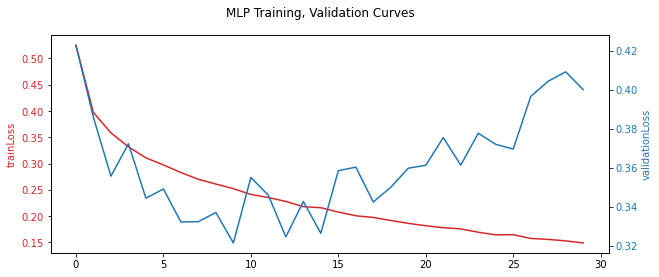

In [14]:
# Hyper parameters for training model
N_EPOCHS = 30
LR = 0.001

# Define the Loss
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# train, validate standard model
modelResults = trainValidateModel(model, criterion, optimizer, train_loader, valid_loader, meanClassificationAccuracyMetric, 'accuracy', device)

In [15]:
def evaluteOnTestData(model, pretrainedModelPath, device, 
                     dataloader_test, metricClass, metricName, modelName):
    import time
    testSetMetric = 0.0
    if pretrainedModelPath is not None:
        if os.path.isfile(pretrainedModelPath) == True:
            model.load_state_dict(torch.load(pretrainedModelPath, map_location=device))

    model.to(device)
    model.eval()
    metricObject = metricClass()
    t = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader_test, total=len(dataloader_test)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            start = time.time()
            y_preds = model(inputs)
            calc_time = time.time() - start
            t += calc_time
        # update batch metric information            
        metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

    testSetMetric = metricObject.compute()    
    print(f'\n{modelName} has {testSetMetric} {metricName} on testData')
    
    inference_time = t/len(dataloader_test)
    return inference_time, testSetMetric

In [16]:
t, testSetMetric = evaluteOnTestData(model, "./MLP.pt", device, test_loader, 
                    meanClassificationAccuracyMetric, "Test_Accuracy", "Custom_MLP")

100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.10it/s]


Custom_MLP has 100.0 Test_Accuracy on testData


In [17]:
def get_zip_size(model):
    import gzip
    import shutil
    import os
    model_name = 'tmp.h5'
    zipped_model_name = 'tmp.h5.gz'
    torch.save(model.state_dict(), model_name)
    with open(model_name, 'rb') as f_in:
        with gzip.open(zipped_model_name, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    unzip_size = os.path.getsize(model_name) * 1e-3
    zip_size = os.path.getsize(zipped_model_name) * 1e-3
    print(f"Model Size = {unzip_size:.3f}KB")
    print(f"Zipped Model Size = {zip_size:.3f}KB")
    os.remove(model_name)
    os.remove(zipped_model_name)
        
    return unzip_size, zip_size

In [18]:
import torch.nn.utils.prune as prune
from copy import deepcopy

In [19]:
# Let's use different pruning percentages for each technique
prunePercentages = np.linspace(0.10, 0.80, 15).tolist()
print([round(x,3) for x in prunePercentages])

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]


In [20]:
def prune_model_global_unstructured(model, layer_type, proportion):
    from copy import deepcopy
    ori_model = deepcopy(model)
    
    module_tups = []
    ori_module_tups = []
    for module, ori_module in zip(model.modules(), ori_model.modules()):
        if isinstance(module, layer_type) and isinstance(ori_module, layer_type):
            module_tups.append((module, 'weight'))
            ori_module_tups.append((ori_module, 'weight'))
            
    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    
    prune.global_unstructured(
        parameters=ori_module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    
    return model, ori_model

In [21]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    ori_model = deepcopy(model)
    
    modules = []
    
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
            modules.append((module, 'weight'))
            
    for name, module in ori_model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    
    for module, _ in modules:
        prune.remove(module, 'weight')

    return model, ori_model

In [22]:
# placeholder to store results
l1_unstructured_accuracies = []
l1_unstructured_size = []
l1_unstructured_inf = []
# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    # unStructuredPruneModel = layer_unstructured_prune(model, perc, nn.Linear)
    removed_model, unStructuredPruneModel = layer_unstructured_prune(model, perc)
    unzipped, zipped = get_zip_size(removed_model)
    # time = print_model_metrics(removed_model, random_input)
    # evaluate the pruned model on test data
    time, acc = evaluteOnTestData(unStructuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "Unstructured Prune")
    l1_unstructured_accuracies.append(acc)
    l1_unstructured_size.append((unzipped, zipped))
    l1_unstructured_inf.append(time)

Model Size = 446.927KB
Zipped Model Size = 389.165KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 98.89it/s]



Unstructured Prune has 81.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 373.050KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.87it/s]



Unstructured Prune has 100.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 355.446KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.26it/s]



Unstructured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 336.386KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.60it/s]



Unstructured Prune has 93.75 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 318.733KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.39it/s]



Unstructured Prune has 93.75 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 300.820KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.52it/s]



Unstructured Prune has 68.75 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 282.317KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 98.52it/s]



Unstructured Prune has 75.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 263.491KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.44it/s]



Unstructured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 244.309KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.02it/s]



Unstructured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 224.258KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.52it/s]



Unstructured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 203.631KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.24it/s]



Unstructured Prune has 62.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 181.966KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.62it/s]



Unstructured Prune has 50.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 161.338KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 106.64it/s]



Unstructured Prune has 62.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 140.695KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.32it/s]



Unstructured Prune has 25.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 119.610KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 98.98it/s]


Unstructured Prune has 18.75 Test accuracy on testData


In [23]:
print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00013 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


0.00019

In [24]:
def layer_structured_prune(model:nn.Module, prunePercentage:float):
    from copy import deepcopy
    ori_model = deepcopy(model)

    module_tups = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module_tups.append((module, 'weight'))
    
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=prunePercentage, n=1, dim=0)

    for name, ori_module in ori_model.named_modules():
        if isinstance(ori_module, torch.nn.Linear):
            prune.ln_structured(ori_module, name='weight', amount=prunePercentage, n=1, dim=0)

    for module, _ in module_tups:
        prune.remove(module, 'weight')
    
    return model, ori_model

In [25]:
# placeholder to store results
l1_structured_accuracies = []
l1_structured_size = []
l1_structured_inf = []
# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    removed_model, structuredPruneModel = layer_structured_prune(model, perc)
    unzipped, zipped = get_zip_size(removed_model)
    # inf = print_model_metrics(removed_model, random_input)
    # evaluate the pruned model on test data
    inf, acc = evaluteOnTestData(structuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune")
    l1_structured_accuracies.append(acc)
    l1_structured_size.append((unzipped, zipped))
    l1_structured_inf.append(inf)

Model Size = 446.927KB
Zipped Model Size = 377.360KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.61it/s]



structured Prune has 81.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 358.761KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.02it/s]



structured Prune has 56.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 338.118KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.49it/s]



structured Prune has 75.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 320.055KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.21it/s]



structured Prune has 56.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 301.837KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.47it/s]



structured Prune has 68.75 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 280.978KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 95.98it/s]



structured Prune has 37.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 262.467KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.85it/s]



structured Prune has 62.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 241.576KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.63it/s]



structured Prune has 31.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 223.346KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.15it/s]



structured Prune has 62.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 205.040KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.44it/s]



structured Prune has 50.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 184.237KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.18it/s]



structured Prune has 18.75 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 165.496KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.67it/s]



structured Prune has 31.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 144.323KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.25it/s]



structured Prune has 0.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 125.934KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.75it/s]



structured Prune has 12.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 107.404KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.40it/s]


structured Prune has 6.25 Test accuracy on testData


In [26]:
def prune_model_global_unstructured(model, layer_type, proportion):
    from copy import deepcopy
    ori_model = deepcopy(model)
    
    module_tups = []
    ori_module_tups = []
    for module, ori_module in zip(model.modules(), ori_model.modules()):
        if isinstance(module, layer_type) and isinstance(ori_module, layer_type):
            module_tups.append((module, 'weight'))
            ori_module_tups.append((ori_module, 'weight'))
            
    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    
    prune.global_unstructured(
        parameters=ori_module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    
    return model, ori_model

In [27]:
def global_unstructured_prune(model:nn.Module, prunePercentage:float):
    from copy import deepcopy
    ori_model = deepcopy(model)
    
    parameters_to_prune = []
    ori_module_tups = []
    for (name, module), (_, ori_module) in zip(model.named_modules(), ori_model.named_modules()):
        if isinstance(module, torch.nn.Linear) and isinstance(ori_module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
            ori_module_tups.append((ori_module, 'weight'))
            
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prunePercentage)
    prune.global_unstructured(ori_module_tups, pruning_method=prune.L1Unstructured, amount=prunePercentage)

    for _, module in parameters_to_prune:
        prune.remove(module, 'weight')
    
    return model, ori_model

In [28]:
# placeholder to store results
global_prune_accuracies = []
global_prune_size = []
global_prune_inf = []
# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    removed_model, globalPruneModel = prune_model_global_unstructured(model, nn.Linear, perc)
    zipped, unzipped = get_zip_size(removed_model)
    # inf = print_model_metrics(removed_model, random_input)
    # evaluate the pruned model on test data
    inf, acc = evaluteOnTestData(globalPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune")
    global_prune_accuracies.append(acc)    
    global_prune_size.append((zipped, unzipped))
    global_prune_inf.append(inf)

Model Size = 446.927KB
Zipped Model Size = 389.136KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.41it/s]



structured Prune has 75.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 372.955KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.19it/s]



structured Prune has 100.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 355.298KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.37it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 336.207KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.03it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 318.583KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.90it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 300.755KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.78it/s]



structured Prune has 100.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 282.208KB


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.57it/s]



structured Prune has 93.75 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 263.418KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.01it/s]



structured Prune has 81.25 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 244.237KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.72it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 224.270KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.99it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 203.617KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.00it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 181.856KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.84it/s]



structured Prune has 87.5 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 161.323KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.28it/s]



structured Prune has 75.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 140.688KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.39it/s]



structured Prune has 50.0 Test accuracy on testData
Model Size = 446.927KB
Zipped Model Size = 119.604KB


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 102.83it/s]


structured Prune has 56.25 Test accuracy on testData


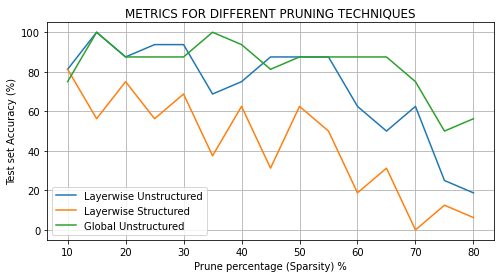

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_accuracies), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_accuracies), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_accuracies), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Test set Accuracy (%)', title = 'METRICS FOR DIFFERENT PRUNING TECHNIQUES')
ax.legend()
ax.grid(True)
plt.show()

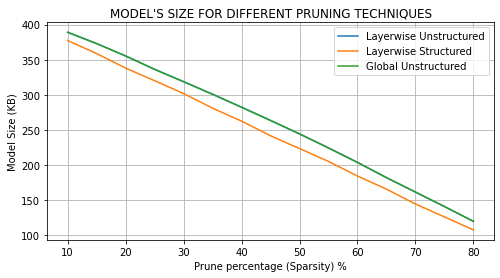

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array([size for (_, size) in l1_unstructured_size]), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array([size for (_, size) in l1_structured_size]), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array([size for (_, size) in global_prune_size]), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Model Size (KB)', title = "MODEL'S SIZE FOR DIFFERENT PRUNING TECHNIQUES")
ax.legend()
ax.grid(True)
plt.show()

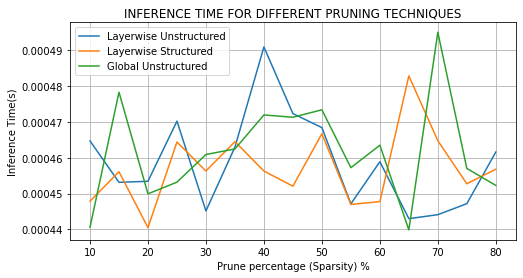

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_inf), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_inf), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_inf), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Inference Time(s)', title = "INFERENCE TIME FOR DIFFERENT PRUNING TECHNIQUES")
ax.legend()
ax.grid(True)
plt.show()

In [32]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00015 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


0.00012

In [33]:
torch.save(model.state_dict(), 'model.h5')

In [34]:
!du -h model.h5
!gzip -qf model.h5
!du -h model.h5.gz

440K	model.h5
408K	model.h5.gz


In [35]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    return model

In [36]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
unStructuredPruneModel = layer_unstructured_prune(model, 0.3)

print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00014 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


0.00015

In [37]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
removed ,StructuredPruneModel = layer_structured_prune(model, 0.1)

print_model_metrics(StructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00015 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


0.00014

In [38]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
removed, globalPruneModel = prune_model_global_unstructured(model, nn.Linear, 0.3)

print_model_metrics(globalPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00014 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


0.00014

In [39]:
import matplotlib
import matplotlib.patches as mpatches

binary_cmap = matplotlib.colors.ListedColormap(['#3D99FF', '#7F7F7F'])
patchList = []
for lab,c in zip([False, True], ['#3D99FF', '#7F7F7F']):
    patchList.append(mpatches.Patch(color=c, label=lab))

def plot_tensor_mask(pt_tensor, ax=None):
    z_np = pt_tensor.detach().cpu().numpy()
    ln = ax.imshow(z_np, cmap = binary_cmap)
    ax.axis('off')
    return ln

In [40]:
def plot_custom_model(model_list, title=''):
    if isinstance(title, list):
        for model, t in zip(model_list, title):
            fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})

            model_masks = dict(model.named_buffers())
            plot_tensor_mask(model_masks['fc1.weight_mask'], axes[0])
            plot_tensor_mask(model_masks['fc2.weight_mask'], axes[1])
            plot_tensor_mask(model_masks['fc3.weight_mask'], axes[2])
            plot_tensor_mask(model_masks['fc4.weight_mask'], axes[3])

            axes[0].set_title('FC Layer1')
            axes[1].set_title('FC Layer2')
            axes[2].set_title('FC Layer3')
            axes[3].set_title('FC Layer4')

            if title is not '':
                plt.suptitle(t)
    else:
        for model in model_list:
            fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})

            model_masks = dict(model.named_buffers())
            plot_tensor_mask(model_masks['fc1.weight_mask'], axes[0])
            plot_tensor_mask(model_masks['fc2.weight_mask'], axes[1])
            plot_tensor_mask(model_masks['fc3.weight_mask'], axes[2])
            plot_tensor_mask(model_masks['fc4.weight_mask'], axes[3])

            axes[0].set_title('FC Layer1')
            axes[1].set_title('FC Layer2')
            axes[2].set_title('FC Layer3')
            axes[3].set_title('FC Layer4')

            if title is not '':
                plt.suptitle(title)

<>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_152279/420285369.py:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if title is not '':
/tmp/ipykernel_152279/420285369.py:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if title is not '':


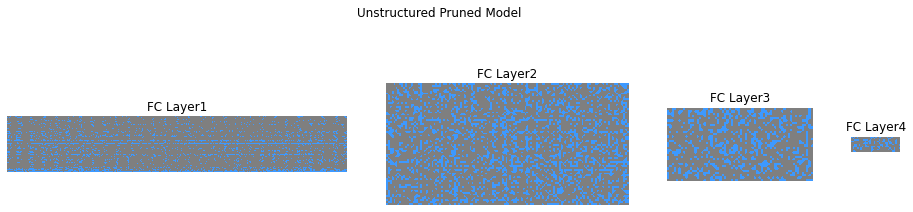

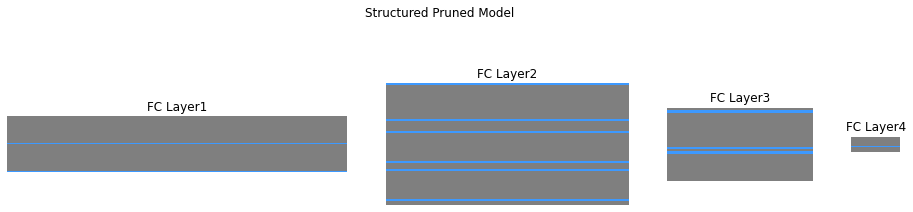

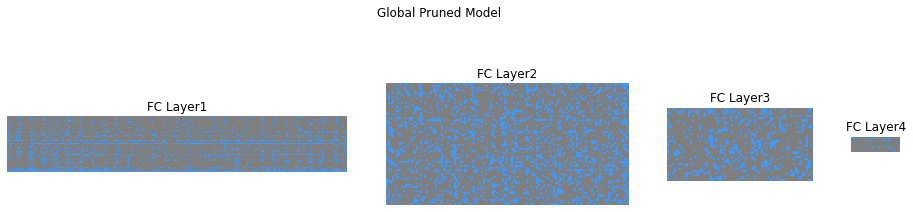

In [41]:
model_list = [unStructuredPruneModel, StructuredPruneModel, globalPruneModel]
title_list = ["Unstructured Pruned Model", "Structured Pruned Model", "Global Pruned Model"]
plot_custom_model(model_list, title=title_list)